# Install dependencies

In [ ]:
%%bash
pip install wds-client --upgrade
pip install terra-notebook-utils --user

In [1]:
import requests
import os
import json
import wds_client
import pandas as pd
import seaborn
from datetime import datetime
import pytz
from terra_notebook_utils import azure_auth

# Define constants

In [2]:
DOMAIN = 'dsde-prod.broadinstitute.org'
WSM_BASE_URL = f'https://workspace.{DOMAIN}/api/workspaces/v1'
LEO_BASE_URL = f'https://leonardo.{DOMAIN}/api/apps/v2'
azure_token = azure_auth.get_azure_access_token()
HEADERS = {
    "Authorization": f"Bearer {azure_token}",
    "Accept": "application/json"
}
WORKSPACE_ID = os.environ['WORKSPACE_ID']
WORKSPACE_STORAGE_CONTAINER_ID = os.environ['WORKSPACE_STORAGE_CONTAINER_ID']
WORKSPACE_STORAGE_CONTAINER_URL = os.environ['WORKSPACE_STORAGE_CONTAINER_URL']
VERSION = 'v0.2'

# Prepare WDS client

In [3]:
def get_wds_url(workspaceId):
    """Get url for WDS."""
    uri = f"{LEO_BASE_URL}/{workspaceId}?includeDeleted=false"
    response = requests.get(uri, headers=HEADERS)
    status_code = response.status_code
    if status_code != 200:
        return response.text
    return json.loads(response.text)

response = get_wds_url(WORKSPACE_ID)
wds_url = response[0]['proxyUrls']['wds']
print(wds_url)

https://lzf42bf0dc63c251179adc6ee67ef00d66ba53808001a58d33.servicebus.windows.net/wds-28d93d5c-9026-49aa-a3cc-e4dc13622528/wds


In [4]:
api_client = wds_client.ApiClient(header_name='Authorization', header_value="Bearer " + azure_token)
api_client.configuration.host = wds_url

# set up all the clients
records_client = wds_client.RecordsApi(api_client)
generalInfo_instance = wds_client.GeneralWDSInformationApi(api_client)
schema_instance = wds_client.SchemaApi(api_client)
client_instance = wds_client.InstancesApi(api_client)

# Read data table into pandas dataframe

In [5]:
records = records_client.get_records_as_tsv(WORKSPACE_ID, VERSION, 'games')
df = pd.read_csv(records, sep='\t')
# Filter out games we haven't analyzed
df = df[df.white_avg_centipawn_loss.notnull()]

In [6]:
df.head()

,sys_name,Black,black_avg_centipawn_loss,BlackElo,BlackRatingDiff,Date,ECO,Event,offset,pgn_file,...,Site,Termination,TimeControl,UTCDate,UTCTime,Variant,White,white_avg_centipawn_loss,WhiteElo,WhiteRatingDiff
0,0,hiepsieunhan,151.285714,1752,-6,2023.04.10,D00,Rated Bullet game,0,https://lz304a1e79fd7359e5327eda.blob.core.win...,...,https://lichess.org/NWQRVM2s,Normal,60+0,2023.04.10,03:35:42,Standard,robitto,37.250000,1769,+6
1,1,OnSlaughter24,64.617021,1835,+5,2023.04.10,A80,Rated Bullet game,434,https://lz304a1e79fd7359e5327eda.blob.core.win...,...,https://lichess.org/XDXTRRTV,Time forfeit,60+0,2023.04.10,01:29:23,Standard,robitto,109.659574,1774,-5
2,10,gseng,93.571429,1773,-5,2023.04.08,A40,Rated Bullet game,7215,https://lz304a1e79fd7359e5327eda.blob.core.win...,...,https://lichess.org/xCuBpMG6,Normal,60+0,2023.04.08,22:42:34,Standard,robitto,30.133333,1804,+5
3,100,SteinsGate-0137894,56.536585,1729,-5,2023.03.31,A40,Rated Bullet game,73489,https://lz304a1e79fd7359e5327eda.blob.core.win...,...,https://lichess.org/o4K6Qoz8,Time forfeit,60+0,2023.03.31,19:18:25,Standard,robitto,0.500000,1751,+6
4,1000,BretzelLiquide,25.130435,1753,+6,2022.07.04,B32,Rated Bullet game,729287,https://lz304a1e79fd7359e5327eda.blob.core.win...,...,https://lichess.org/5c63Zkdm,Normal,60+0,2022.07.04,19:19:55,Standard,robitto,46.608696,1777,-7


# 1. Does engine performance correlate to result?

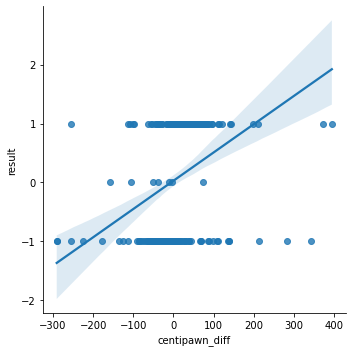

In [25]:
traits_for_analysis = pd.DataFrame()
# Higher centipawn_diff -> better white performance
traits_for_analysis['centipawn_diff'] = df['black_avg_centipawn_loss'] - df['white_avg_centipawn_loss']
def result_to_numeric(result):
    if result == "1-0":
        return 1
    elif result == "0-1":
        return -1
    return 0
traits_for_analysis['result'] = df['Result'].map(result_to_numeric)
seaborn.lmplot(x='centipawn_diff',y='result',data=traits_for_analysis,fit_reg=True)

# 2. Do I play better at certain times of day?

<AxesSubplot:xlabel='hour_of_day_est'>

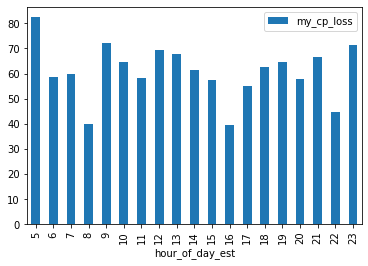

In [116]:
traits_for_analysis = pd.DataFrame()
def my_cp_loss(white, black, black_cp, white_cp):
    if white == 'robitto':
        return white_cp
    return black_cp
def hour_of_day(utc_time):
    d = datetime.strptime(utc_time, '%H:%M:%S')
    est = pytz.timezone('US/Eastern')
    d = d.astimezone(est)
    return d.hour
traits_for_analysis['hour_of_day_est'] = df['UTCTime'].map(hour_of_day)
traits_for_analysis['my_cp_loss'] = df.apply(lambda x: my_cp_loss(x['White'], x['Black'], x['black_avg_centipawn_loss'], x['white_avg_centipawn_loss']), axis=1)
traits_for_analysis = traits_for_analysis.groupby(['hour_of_day_est']).mean()
traits_for_analysis.plot.bar()

# Do I play better with certain openings?

<AxesSubplot:xlabel='eco'>

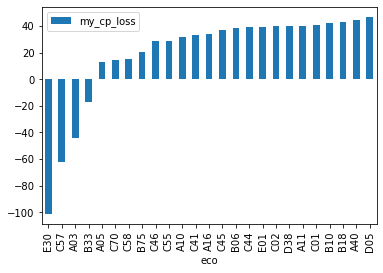

In [114]:
traits_for_analysis = pd.DataFrame()
def eco_unhex(eco):
    return int(eco, 16)
traits_for_analysis['eco'] = df['ECO']
traits_for_analysis['my_cp_loss'] = df.apply(lambda x: my_cp_loss(x['White'], x['Black'], x['black_avg_centipawn_loss'], x['white_avg_centipawn_loss']), axis=1)
traits_for_analysis = traits_for_analysis.groupby(['eco']).mean()
traits_for_analysis.sort_values('my_cp_loss').head(25).plot.bar()